In [0]:
#!pip install tensorflow-gpu==2.0.0-alpha0

In [1]:
from google.colab import drive
drive.mount('/content/drive')
!mkdir -p drive

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
import os
import cv2 as cv
import argparse
import imutils
import numpy as np
from skimage.filters import threshold_local
from google.colab.patches import cv_imshow
from PIL import Image, ImageEnhance
import matplotlib.pyplot as plt
from scipy.interpolate import splprep, splev
import np_utils

from __future__ import absolute_import, division, print_function, unicode_literals
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential, load_model
from keras.layers import Dense, Activation, Dropout, LeakyReLU, Flatten
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.layers.convolutional import Conv2D, MaxPooling2D, Convolution2D

Using TensorFlow backend.


# Paths

In [0]:
img_path = r'drive/My Drive/carton_counter/carton_test.jpg'

train_dir = r'drive/My Drive/carton_counter/train/'
train_dir_sqr = r'drive/My Drive/carton_counter/train/square/'
train_dir_str = r'drive/My Drive/carton_counter/train/star/'
train_dir_crc = r'drive/My Drive/carton_counter/train/circle/'
train_dir_tri = r'drive/My Drive/carton_counter/train/triangle/'

val_dir = r'drive/My Drive/carton_counter/val/'
val_dir_sqr = r'drive/My Drive/carton_counter/val/square/'
val_dir_str = r'drive/My Drive/carton_counter/val/star/'
val_dir_crc = r'drive/My Drive/carton_counter/val/circle/'
val_dir_tri = r'drive/My Drive/carton_counter/val/triangle/'

# Global Variables

In [0]:
batch_size = 128
epochs = 15
img_size = 100 #size of image fed into model

In [19]:
print(len(os.listdir(train_dir+"square")))

3387


# Functions

In [0]:
def flatten(dimData, images):
  images = np.array(images)
  images = images.reshape(len(images), dimData)
  images = images.astype('float32')
  images /=255
  return images

In [0]:
def get_data(train_dir, size):
  folders, labels, images, class_lbls = os.listdir(train_dir), [], [], {}
  for folder in folders:
    print("Getting data from folder:", folder, "-----------------------------------------------")
    counter = 0
    class_lbls[folder] = folders.index(folder)
    for path in os.listdir(train_dir+folder):
        if counter <= size:
          img = cv.imread(train_dir+folder+'/'+path,0)
          #cv_imshow(img)
          images.append(cv.resize(img, (img_size, img_size)))
          labels.append(folders.index(folder))
          counter += 1
  images = np.array(images)
  labels = np.array(labels)
  return images, labels, class_lbls

# Loading Data for Classifier

In [0]:
images, labels, class_lbls = get_data(train_dir, 2000)
print(len(images))
print(len(labels))
print(class_lbls)

# Saving a loading numpy arrays from file

np.save('drive/My Drive/carton_counter/np_arrays/images.npy', images)
np.save('drive/My Drive/carton_counter/np_arrays/labels.npy', labels)

#images = np.load(r'drive/My Drive/carton_counter/np_arrays/images.npy')
#labels = np.load(r'drive/My Drive/carton_counter/np_arrays/labels.npy')


#break data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = 0.2, random_state = 0)
print("Finished loading data for training -----------------------------------------------")

print(len(x_train))
print(len(y_train))
print(len(x_test))
print(len(y_test))

#flatten data
dataDim = np.prod(images[0].shape)
train_data  = flatten(dataDim, x_train)
test_data = flatten(dataDim, x_test)

#change labels to categorical
train_labels = np.array(y_train)
test_labels = np.array(y_test)
train_labels_one_hot = to_categorical(train_labels)
test_labels_one_hot = to_categorical(test_labels)

#determine the number of classes
classes = np.unique(train_labels)
nClasses  = len(classes)

Getting data from folder: square -----------------------------------------------
Getting data from folder: circle -----------------------------------------------


# Training

In [0]:
# Initialising the CNN
classifier = Sequential()

# Step - 1 Convolution
classifier.add(Convolution2D( 16, 3, 3, input_shape=(28, 28, 3), activation='relu'))
# Step - 2 Pooling
classifier.add(MaxPooling2D(pool_size=(2, 2)))

classifier.add(Convolution2D(32, 3, 3, activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))
# Step - 3 Flattening
classifier.add(Flatten())
# Step - 4 Full connection -> First layer input layer then hidden layer
# and last softmax layer
classifier.add(Dense(56, activation='relu', kernel_initializer='uniform'))
classifier.add(Dense(3, activation='softmax', kernel_initializer='uniform'))

# Compiling the CNN
classifier.compile(
    optimizer='adam', 
    loss='categorical_crossentropy', 
    metrics=['accuracy'])

model.fit(train_data, 
          train_labels_one_hot, 
          batch_size = 128, 
          epochs=25, 
          verbose=1,
          validation_data=(test_data, test_labels_one_hot))

#test model
[test_loss, test_acc] = model.evaluate(test_data, test_labels_one_hot)
print("Evaluation result on Test Data : Loss = {}, accuracy = {}".format(test_loss, test_acc))
#save model
model.save(r'drive/My Drive/carton_counter/models/model.h5')

# Predict Results

In [0]:
folder, test_imgs = os.listdir(test_dir), []
for f in folder:
  img = cv.imread(test_dir+'/'+f,0)
  #cv_imshow(img)
  test_imgs.append(cv.resize(img, (img_size, img_size)))
  #test_imgs.append(img)

test_imgs_np = np.array(test_imgs)
dataDim = np.prod(test_imgs[0].shape)
test_imgs_np = flatten(dataDim, test_imgs_np)

['square', 'circle', 'triangle', 'star']
[1 2 3 0 0 3 3 1 1]


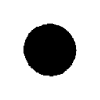

This image belongs to class: circle


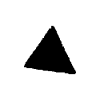

This image belongs to class: triangle


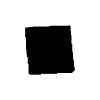

This image belongs to class: star


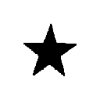

This image belongs to class: square


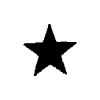

This image belongs to class: square


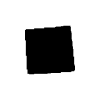

This image belongs to class: star


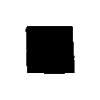

This image belongs to class: star


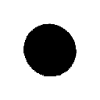

This image belongs to class: circle


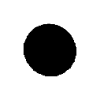

This image belongs to class: circle


In [15]:
# Predict Results
print(class_lbls)
print(prediction)

model = load_model(r'drive/My Drive/carton_counter/models/model.h5')
prediction = model.predict_classes(test_imgs_np)

index = 0
for i in prediction:
  img = test_imgs[index]
  cv_imshow(img)
  print("This image belongs to class:", class_lbls[i])
  index += 1


In [0]:
print("Total training images:", len(x_train))
print("Total validation images:", len(y_train))
print("Total test images:", len(x_test))
print("Total validation test images:", len(y_test))
print(x_train.shape)

# Train

In [0]:
model = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(img_size, img_size ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

In [0]:
model.fit(
    x_train, 
    y_train,
    batch_size = 128,
    epochs = 1
)


In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

# Shape Detector

In [0]:
class ShapeDetector:
  def __init__(self):
    self.cartons = 0

  def detect(self, c):
    # initialize the shape name and approximate the contour
    shape = "unidentified"
    peri = cv.arcLength(c, True)
    approx = cv.approxPolyDP(c, 0.015 * peri, True)

    #epsilon = 0.1*cv.arcLength(c,True)
    #approx = cv.approxPolyDP(c,epsilon,True)

    # if the shape has 4 vertices, it is either a square or a rectangle
    if len(approx) == 4:
      # compute the bounding box of the contour and use the bounding box to compute the aspect ratio
      (x, y, w, h) = cv.boundingRect(approx)
      ar = w / float(h)

      shape = "square" if ar >= 0.95 and ar <= 1.05 else "rectangle"
      self.cartons += 1
      shape += (" " + str(self.cartons))
      
      return shape, (x, y, w, h)
    else:
      return None

# Auto Canny

In [0]:
def auto_canny(image, sigma=0.33):
	# compute the median of the single channel pixel intensities
	v = np.median(image)
 
	# apply automatic Canny edge detection using the computed median
	lower = int(max(0, (1.0 - sigma) * v))
	upper = int(min(255, (1.0 + sigma) * v))
	edged = cv.Canny(image, lower, upper)
 
	# return the edged image
	return edged

# Image Translation

In [0]:
def translate_img(image, task):
  # Invert the Bits if the background is white
  image = cv.bitwise_not(image)
  cv_imshow(imutils.resize(image, width = 500))
  # convert the image to grayscale
  gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
  cv_imshow(imutils.resize(gray, width = 500))
  # blur the image
  #blurred = cv.GaussianBlur(gray, (5, 5), 0)
  blurred = cv.bilateralFilter(gray, 11, 17, 17)
  cv_imshow(imutils.resize(blurred, width = 500))

  if task == "thresh":
    # Contour Threshold 
    print("Threshhold-----------")
    thresh = cv.threshold(blurred, 100, 255, 0)[1]
    cv_imshow(imutils.resize(thresh, width = 500))
    # Find contours for thresholds 
    cnts = cv.findContours(thresh.copy(), cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sorted(cnts, key = cv.contourArea, reverse = True)[:30]
    return cnts

  elif task == "edge":
    # Countour Edges
    print("Edged-----------")
    #edged = auto_canny(blurred)
    edged = cv.Canny(blurred, 30, 200)
    cv_imshow(imutils.resize(edged, width = 500))
    # Find contours for edges 
    cnts = cv.findContours(edged.copy(), cv.RETR_LIST, cv.CHAIN_APPROX_NONE)
    cnts = imutils.grab_contours(cnts)
    cnts = sorted(cnts, key = cv.contourArea, reverse = True)
    return cnts

  else: 
    pass

# Detect Shapes

In [0]:
# load the image and resize it to a smaller factor so thatthe shapes can be approximated better
image = cv.imread(img_path)
orig_image = image.copy()

# Edge Analysis
edged = translate_img(image, "edge")
cv.drawContours(image, edged, -1, (0, 0, 0), 2)
cv_imshow(imutils.resize(image, width = 500))

# Thresh Analysis
thresh = translate_img(image, "thresh")
sd = ShapeDetector()

# loop over the contours
for c in thresh:
  result = sd.detect(c)
  if result != None:
    shape = result[0]
    (x, y, w, h) = result[1]
    cv.rectangle(image,(x,y),(x+w,y+h),(255,0,0),2)
    cv.putText(image, shape, (x, y), cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)
  else:
    continue


# show the output image
print("Result-----------")    
cv_imshow(imutils.resize(image, width = 800))

#print("Smoothened Contours-----------")
#img = image
#smooth_cnts = smoothen_cnts(img, cnts)
#cv_imshow(imutils.resize(image, width = 800))
print("Number of Cartons:", sd.cartons)